## Linear Regression and RANSAC

In [1]:
# Load the modules we need
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn import linear_model, datasets

In [2]:
#  Create some intial data
n_samples = 1000

X, y = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      random_state=0)

In [3]:
# Add some outlier data
np.random.seed(0)
n_outliers = 50
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

In [4]:
# Create some test positions for for the lines we will draw
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
print(y.shape)
print(X.shape)

(1000,)
(1000, 1)


In [5]:
#This is the cell you need to replace to complete Task 2.
#Fit line using all data.
lr = linear_model.LinearRegression()
lr.fit(X, y)
line_y = lr.predict(line_X)
print(line_y)

[-174.38323639 -120.21087252  -66.03850865  -11.86614478   42.30621909
   96.47858295  150.65094682  204.82331069]


In [6]:
class LinearRegressionIsGivingMeDepression():
    def fit(self,X,y):
        
        #reshape y:
        reshaped = y.reshape((-1,1))
        
        #create the elements that solve y = mx+c using the closed method
        
        alpha = np.sum(np.multiply(X,reshaped))
        beta = np.sum(np.square(X))
        rho = np.sum(X)
        delta = np.sum(reshaped)
        N = len(reshaped)
        
        #put the elements into the matrix and compute m and c
        
        firstMatrix = np.array([[beta,rho],[rho,N]])
        secondMatrix = np.array([[alpha],[delta]])
        
        unknowns = np.dot(np.linalg.inv(firstMatrix),secondMatrix)
        
        self.m = unknowns.item(0)
        self.c = unknowns.item(1)
        
    def predict(self,X):
        reshaped = X.reshape((-1))
        data = [(self.m*dataPoint+self.c) for dataPoint in reshaped]
        return data

In [7]:
# My code
# Fit line using all data.
lr = LinearRegressionIsGivingMeDepression()
lr.fit(X, y)
line_y = lr.predict(line_X)
print(line_y)

[-174.38323639022238, -120.2108725212071, -66.03850865219182, -11.866144783176553, 42.30621908583872, 96.47858295485399, 150.65094682386925, 204.82331069288452]


In [8]:
# This is the cell you need to replace to complete Task 3.
# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)

# Predict data of estimated models
line_y_ransac = ransac.predict(line_X)
print(line_y_ransac)

# Label the if source data is inlier or outlier
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

[-249.81104528 -167.72571369  -85.64038211   -3.55505052   78.53028107
  160.61561265  242.70094424  324.78627583]


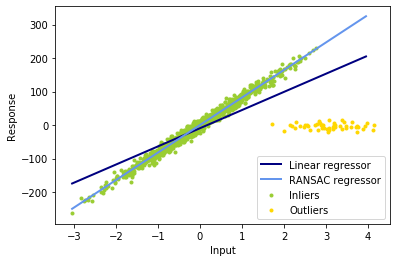

In [9]:
lw = 2

doing_linear = True
doing_ransac = True

if (doing_linear):
    plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')

if (doing_ransac):
    plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.', label='Inliers')
    plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.', label='Outliers')
    plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw, label='RANSAC regressor')
else:
    plt.scatter(X, y, color='yellowgreen', marker='.', label='Data')
    
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

In [10]:
#My code
#Note for revision: this is the algorithm for RANSAC:
# 1) Take in the arbitrary data
# 2) have iterations as usual computed by the formula
# 3) pick random points and compute inliers and outliers
# 4) most importantly CAPITALISE on the inliers and use them for the random point generation
# 5) At the very end compute the formula for the line as there will be no more changes between inliers and outliers

from scipy import stats

class RANSAC():
    
    
    #The RANSAC algorithm code
    def fit(self,X,y):
        
        #using the formula from the slides this should equate to 2
        numberOfIterations = round(math.log(0.01)/math.log(1-((1-0.05)**2)))
        bestModel = None
        
        #min inliers at the start
        totalInliers = X.shape[1] + 1
        
        #inlier threshold
        inlierThreshold = stats.median_absolute_deviation(y)
        
        for num in range (numberOfIterations):
            
            #initial check just in case could do better
            if (not totalInliers == X.shape[1] + 1):
                sample = np.random.choice(len(self.inliers),2, replace=False)
            else:
                sample = np.random.choice(len(y),2, replace=False)
                num = 0

            #generation of a line using random points
            model_params = self.generateModel(X[sample],y[sample])
            
            #time to evaluate the line:
            model_performance = self.evaluateModel(X,y,model_params,inlierThreshold)
            
            if(model_performance>totalInliers):
                bestModel = model_params
                totalInliers = model_performance
                
            
            if(model_performance>totalInliers):
                while(model_performance > totalInliers):
                    #choosing 2 points randomly from the array
                    sample = np.random.choice(len(self.inliers),2, replace=False)
            
                    #generation of a line using random points
                    model_params = self.generateModel(X[sample],y[sample])
            
                    #time to evaluate the line:
                    model_performance = self.evaluateModel(X,y,model_params,inlierThreshold)
                    print(model_performance)
            
                    if model_performance < totalInliers:
                        break
        
                    if model_performance > totalInliers:
                        bestModel = model_params
                        totalInliers = model_performance
                        
        #compute lines without outliers at the very end when separated
        totInliersX = np.array([X[i] for i in self.inliers])
        totInliersy = np.array([y[i] for i in self.inliers])
        fin = self.generateModel(totInliersX ,totInliersy)
        
        self.model_params = fin
            
    
    #how to compute error between points
    def evaluateModel(self,X,y,model_params,inlierThreshold):
        self.inliers = list()
        self.outliers = list()
        count = 0
        
        reshaped = X.reshape((-1))
        m = model_params.item(0)
        c = model_params.item(1)
        data = [(m*dataPoint+c) for dataPoint in reshaped]
        
        #now need to do a distance check for the points to the line:
        for i in range(len(data)):
            a = np.array(data[i])
            b = np.array(y[i])
            dist = np.linalg.norm(a-b)
            
            if dist<inlierThreshold:
                self.inliers.append(i)
                count = count+1
            else:
                self.outliers.append(i)
        return count

    
    #function that generates an m and a c for the model no errors here
    def generateModel (self,X,y):
        
        #reshape y:
        reshaped = y.reshape((-1,1))
        #create the elements that solve y = mx+c using the closed method
        
        alpha = np.sum(np.multiply(X,reshaped))
        beta = np.sum(np.square(X))
        rho = np.sum(X)
        delta = np.sum(reshaped)
        N = len(reshaped)
        
        #put the elements into the matrix and compute m and c
        
        firstMatrix = np.array([[beta,rho],[rho,N]])
        secondMatrix = np.array([[alpha],[delta]])
        
        unknowns = np.dot(np.linalg.inv(firstMatrix),secondMatrix)
        return unknowns
        
   
    #take in the X values and determine y-values for them in the model no errors here 
    def predict(self,X):
        reshaped = X.reshape((-1))
        m = self.model_params.item(0)
        c = self.model_params.item(1)
        data = [(m*dataPoint+c) for dataPoint in reshaped]
        return data

In [11]:
# Task 3
# Robustly fit linear model with RANSAC algorithm
ransac = RANSAC()
ransac.fit(X,y)

# Predict data of estimated models
line_y_ransac = ransac.predict(line_X)
print(line_y_ransac)

# Label the if source data is inlier or outlier
inlier_mask = ransac.inliers
outlier_mask = ransac.outliers

[-249.81104528159992, -167.7257136943336, -85.6403821070673, -3.555050519800987, 78.53028106746532, 160.61561265473165, 242.70094424199795, 324.78627582926424]


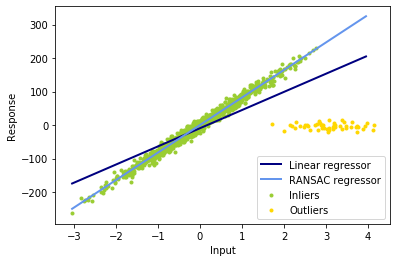

In [12]:
lw = 2

doing_linear = True
doing_ransac = True

if (doing_linear):
    plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')

if (doing_ransac):
    plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.', label='Inliers')
    plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.', label='Outliers')
    plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw, label='RANSAC regressor')
else:
    plt.scatter(X, y, color='yellowgreen', marker='.', label='Data')
    
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()